In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using NetworkLayout

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

PyObject <module 'pandas' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/pandas/__init__.py'>

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

In [6]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

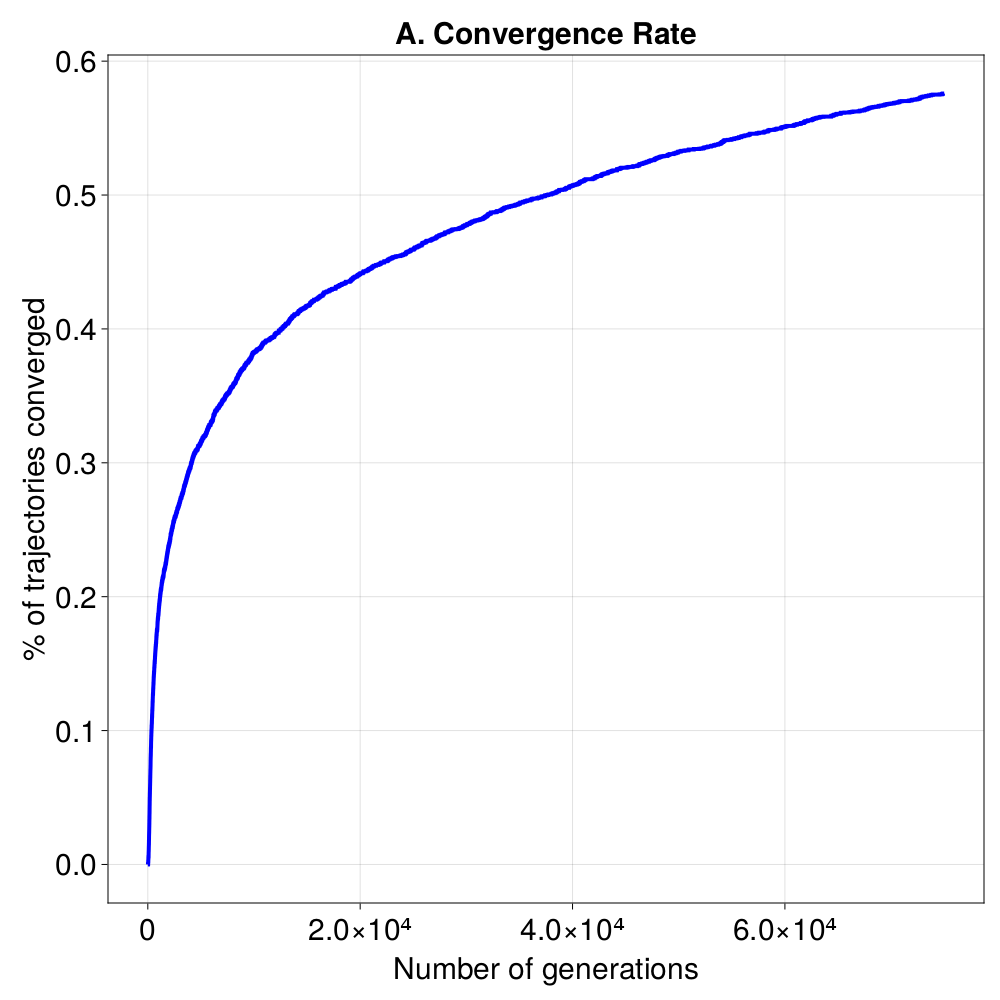

In [7]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [8]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);

In [9]:
sim_m = copy(data["fund_dmat_cell"])
conv = copy(data["converged"]);

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];


In [10]:
class_labels_u = unique(class_labels);

In [11]:
color_name = ["purple","red","green","yellow","blue","pink"]

color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 5 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "mutual_inh"    => "green"
  "No assignment" => "purple"

In [12]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(t->map(x->x[2]+x[1],unique(t)),fitness_traj_b);

# fitness_traj_u = map(t->map(x->x[2]+x[1],t),fitness_traj_b);

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

In [13]:
function get_mutant_n_dist(g_traj)
    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    return sum(g_traj_diff .!= 0.,dims = 1)[1,:]
end

function get_mutant_dist(g_traj)
    g_traj_diff = (g_traj[:,2:end] .- g_traj[:,1:end-1]) ./ map(x-> x == 0 ? 1. : x, g_traj[:,1:end-1])
    
    return [filter(x->x .!= 0.,v) for v in eachcol(g_traj_diff)]
end

function get_fitness_delta(f_traj)
    f_traj_diff = f_traj[2:end] .- f_traj[1:end-1]
    return f_traj_diff
end

function get_mutation_id(g_traj)

    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    mut_id = [findall(x-> x .!= 0, y) for y in eachcol(g_traj_diff)]

    return mut_id
end


weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [14]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [15]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

In [16]:
clust_labels = copy(class_labels);

In [17]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->x[1:end-1],fitness_traj);

actual_networks = map(x->[x[:,j] for j in 1:size(x[:,1:end-1],2)],geno_traj);

actual_mutant = map(x->[j for j in 1:size(x[:,1:end-1],2)],geno_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label_am = [[(mut_number=mut_number,midl...) for (mut_number,midl) in zip(actual_mutant[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_an = [[(existing_network=network,midl...) for (network,midl) in zip(actual_networks[i],mut_id_size_label_am[i])] for i in 1:length(mut_id_size_label_am)];

mut_id_size_label_af = [[(existing_fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label_an[i])] for i in 1:length(mut_id_size_label_an)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [18]:
function condition_data(return_var,condition_var,condition_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

function condition_data_return_tuples(condition_var,condition_values,data)

    return filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)
end

function condition_data_incl(return_var,condition_var,condition_values,incl_var,incl_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]) & all([value ∈ x[var] for (var,value) in zip(incl_var,incl_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

condition_data_incl (generic function with 1 method)

In [19]:
r1 = condition_data((:traj_id,:existing_fitness,:fitness_delta,:existing_network,:mut_size,:mut_id),[:traj_id,:mut_number],[1,1],all_mut_info);
r2 = condition_data((:traj_id,:existing_fitness,:fitness_delta,:existing_network,:mut_size,:mut_id),[:traj_id,:mut_number],[1,2],all_mut_info);


In [20]:
r1

(traj_id = [1], existing_fitness = [-0.9985165945734575], fitness_delta = [0.28350780633005224], existing_network = [[0.0, 0.0, -0.21577059555519695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2490335893436255, 0.0, 0.0]], mut_size = [[1.2944900116518976, 2.379949492671237]], mut_id = [[3, 9]])

In [21]:
r2

(traj_id = [1], existing_fitness = [-0.7150087882434053], fitness_delta = [0.10500009964904344], existing_network = [[0.0, 0.0, -0.4950834763095807, 0.0, 0.0, 0.0, 0.0, 0.0, 2.379949492671237, 1.2490335893436255, 0.0, 0.0]], mut_size = [[0.42599171753119275]], mut_id = [[10]])

In [68]:
function get_current_state(fitness_traj,state_traj,fitness_time)
    latest_fitness_id = map(ft->maximum(findall(f->f <= fitness_time,ft)),fitness_traj)

    latest_fitness = [fitness_traj[traj_id][f_id] for (traj_id,f_id) in enumerate(latest_fitness_id)]

    latest_network = reduce(hcat,[state_traj[traj_id][:,f_id] for (traj_id,f_id) in enumerate(latest_fitness_id)])

    return latest_fitness, latest_network

end

function get_current_adj(epsilon,metric,fitness_traj,state_traj,fitness_time)

    ft, gt = get_current_state(fitness_traj,state_traj,fitness_time)

    dmat = pairwise(metric,gt)

    adj = dmat .<= epsilon

    return ft, adj
end

function draw_current_graph(epsilon,metric,fitness_traj,state_traj,fitness_time)

    fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 22.)

    ax = Axis(fig[1,1])

    ft, adj = get_current_adj(epsilon,metric,fitness_traj,state_traj,fitness_time)

    g = SimpleGraph(adj)

    graphplot!(ax,g,layout = Spring(),node_color = ft .+ 2.)

    return fig

end

function draw_current_graph!(ax,epsilon,metric,fitness_traj,state_traj,fitness_time)

    ft, adj = get_current_adj(epsilon,metric,fitness_traj,state_traj,fitness_time)

    g = SimpleGraph(adj)

    graphplot!(ax,g,layout = x->Spring(),node_color = ft .+ 2.)

    return fig

end

# function draw_current_graph!(ax,g_end,epsilon,metric,fitness_traj,state_traj,fitness_time)

#     ft, adj = get_current_adj(epsilon,metric,fitness_traj,state_traj,fitness_time)

#     g = SimpleGraph(adj)

#     graphplot!(ax,g,layout = x->Spring(g_end),node_color = ft .+ 2.)

#     return fig

# end

function get_current_graph(epsilon,metric,fitness_traj,state_traj,fitness_time)

    ft, adj = get_current_adj(epsilon,metric,fitness_traj,state_traj,fitness_time)

    return ft,SimpleGraph(adj)

end

get_current_graph (generic function with 1 method)

In [27]:
ft,gt = get_current_state(fitness_traj,geno_traj,0)

([-0.5199999999978607, -0.5200000051266702, -0.08505009887210903, -0.5200000000196074, -0.5200000041237798, -0.5200152945992209, -0.5200002865129376, -0.52, -0.5201079080421147, -0.5361845858231833  …  -0.5200000000012279, -0.5200000117157096, -0.044999991529064094, -0.6404174629673887, -0.15422288226578004, -0.5200187918528805, -0.07501727651139467, -0.5200001706848671, -0.52000000000001, -0.5199999999998046], [0.09480256397430518 0.0 … 0.21877614181885363 0.2118898974035143; -1.6260667916966933 0.0 … -6.4990001875188375 -2.045952003657555; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [31]:
initial_fitness

-0.9985165945734575

In [64]:
epsilon = 2.
metric = Euclidean()

fitness_time = -0.2

# draw_current_graph(epsilon,metric,fitness_traj,geno_traj,fitness_time)

-0.2

In [81]:
fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 22.)

ax = Axis(fig[1,1])

# ft, g_end = get_current_graph(epsilon,metric,fitness_traj,geno_traj,1.)

# record(fig, "evolution_test.mp4", LinRange(initial_fitness+eps(),1.,10);framerate = 2) do ft
#     # sleep(1/fps)
#     empty!(ax)
#     draw_current_graph!(ax,g_end,epsilon,metric,fitness_traj,geno_traj,ft)
#     # autolimits!(ax)
# end

# start with ened layout. then for each node, it keeps its final position at all times through simulation

Axis with 0 plots:


In [130]:
epsilon = 6.

n_conn_comp = []

for ft in LinRange(initial_fitness+eps(),1.,100)

    _, g = get_current_graph(epsilon,metric,fitness_traj,geno_traj,ft)

    # c_max = maximum(map(x->length(x),connected_components(g)))

    c_max = maximum(map(x->length(x),maximal_cliques(g)))

    push!(n_conn_comp,c_max)

end

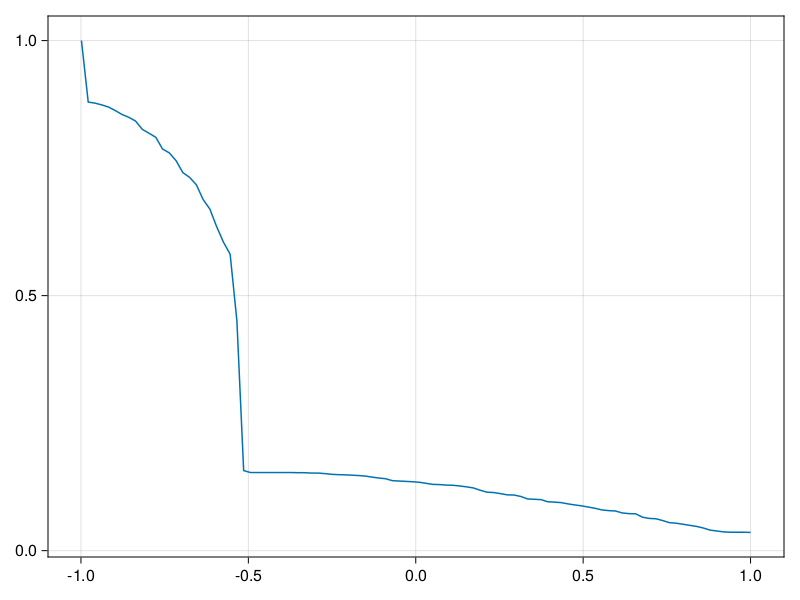

In [109]:
CairoMakie.lines(LinRange(initial_fitness+eps(),1.,100),[i/length(geno_traj) for i in n_conn_comp])

In [83]:
top_traj = map(gt->sign.(gt),geno_traj);

In [110]:
n_conn_comp = []

metric = Hamming()

epsilon = 1

for ft in LinRange(initial_fitness+eps(),1.,100)

    _, g = get_current_graph(epsilon,metric,fitness_traj,top_traj,ft)

    c_max = maximum(map(x->length(x),connected_components(g)))

    push!(n_conn_comp,c_max)

end

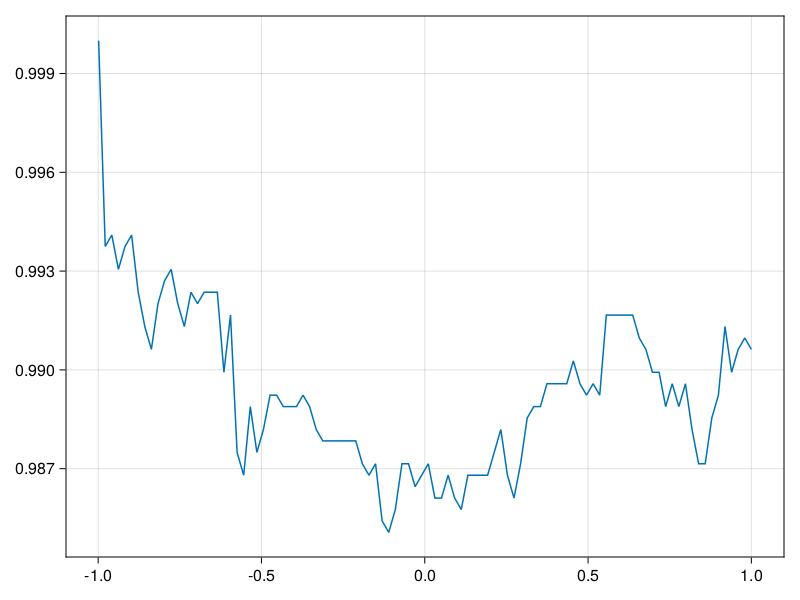

In [111]:
CairoMakie.lines(LinRange(initial_fitness+eps(),1.,100),[i/length(geno_traj) for i in n_conn_comp])

In [112]:
n_conn_comp

100-element Vector{Any}:
 2879
 2861
 2862
 2859
 2861
 2862
 2857
 2854
 2852
 2856
    ⋮
 2842
 2842
 2846
 2848
 2854
 2850
 2852
 2853
 2852

In [114]:
ft,gt = get_current_state(fitness_traj,top_traj,0.)

([-0.5199999999978607, -0.5200000051266702, -0.08505009887210903, -0.5200000000196074, -0.5200000041237798, -0.5200152945992209, -0.5200002865129376, -0.52, -0.5201079080421147, -0.5361845858231833  …  -0.5200000000012279, -0.5200000117157096, -0.044999991529064094, -0.6404174629673887, -0.15422288226578004, -0.5200187918528805, -0.07501727651139467, -0.5200001706848671, -0.52000000000001, -0.5199999999998046], [1.0 0.0 … 1.0 1.0; -1.0 0.0 … -1.0 -1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [118]:
dmat = pairwise(Hamming(),gt);

In [121]:
adj = dmat .<= 1

2879×2879 BitMatrix:
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  1  0     0  0  1  0  0  0  0  1  0  1  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  1  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱           ⋮              ⋮        
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0

In [122]:
g = SimpleGraph(adj)

{2879, 111106} undirected simple Int64 graph

┌ Warning: Since there are a lot of edges (111106 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie /Users/boothh/.julia/packages/GraphMakie/nvoJZ/src/recipes.jl:452
┌ Warning: Since there are a lot of edges (111106 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie /Users/boothh/.julia/packages/GraphMakie/nvoJZ/src/recipes.jl:452


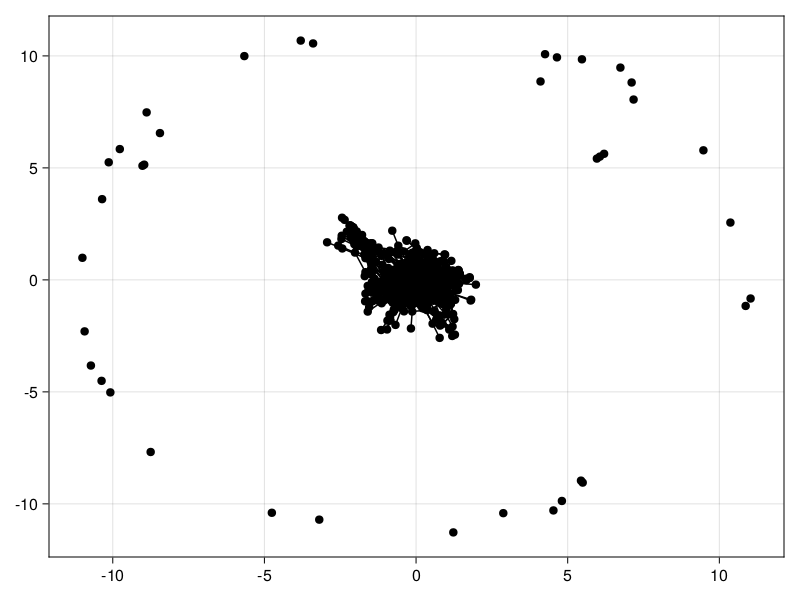

In [124]:
graphplot(g)

In [127]:
mcl = maximal_cliques(g)

1827-element Vector{Vector{Int64}}:
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  839, 1027, 1255, 916, 804, 2734, 2382, 516, 87, 157]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  1594, 229, 2417, 1890, 911, 1435, 2626, 1184, 2369, 1272]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  1420, 1280, 1398, 893, 1653, 1572, 1763, 1342, 2157, 2635]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  2792, 2261, 1607, 2745, 930, 476, 501, 1355, 2027, 637]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  883, 912, 1742, 2085, 251, 204, 2592, 428, 2150, 187]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712  …  1378, 2870, 1492, 975, 2623, 2792, 2485, 878, 2707, 1839]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712, 74, 1378, 2870, 1492, 975, 2623, 2792, 1344, 185, 1886]
 [2108, 196, 1638, 1370, 1112, 2507, 1657, 2483, 19, 712, 74, 1378, 2870, 1492, 975, 2623, 2792, 1596, 680]
 [1175, 2815, 290, 2257, 1929, 759]
 [

In [129]:
mcl[1]

36-element Vector{Int64}:
 2108
  196
 1638
 1370
 1112
 2507
 1657
 2483
   19
  712
    ⋮
 1027
 1255
  916
  804
 2734
 2382
  516
   87
  157